In [ ]:
from google.colab import drive    # Google Drive 패키지 불러오기
import os

drive.mount('/content/gdrive/')
os.chdir('/content/gdrive/My Drive/Colab Notebooks/datascience')

Mounted at /content/gdrive/


In [ ]:
# package import
from torchvision import models
from torchvision import transforms
from PIL import Image
import argparse
import torch
import torchvision
import torch.nn as nn
import numpy as np

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# image loader
def load_image(image_path, transform=None, max_size=None, shape=None):
    """Load an image and convert it to a torch tensor."""
    image = Image.open(image_path)
    
    if max_size:
        scale = max_size / max(image.size)
        size = np.array(image.size) * scale
        image = image.resize(size.astype(int), Image.ANTIALIAS)
    
    if shape:
        image = image.resize(shape, Image.LANCZOS)
    
    if transform:
        image = transform(image).unsqueeze(0)
    
    return image.to(device)

# CNN feature extractor
class VGGNet(nn.Module):
    def __init__(self):
        """Select conv1_1 ~ conv5_1 activation maps."""
        super(VGGNet, self).__init__()
        self.select = ['0', '5', '10', '19', '28'] 
        self.vgg = models.vgg19(pretrained=True).features
        
    def forward(self, x):
        """Extract multiple convolutional feature maps."""
        features = []
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.select:
                features.append(x)
        return features

In [ ]:
def main(config):
    
    # Image preprocessing
    # VGGNet was trained on ImageNet where images are normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
    # We use the same normalization statistics here.
    transform = transfomage same size as the content image
    content = load_imarms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), 
                             std=(0.229, 0.224, 0.225))])
    
    # Load content and style images
    # Make the style ige(config['content'], transform, max_size=config['max_size'])
    style = load_image(config['style'], transform, shape=[content.size(2), content.size(3)])
    
    # Initialize a target image with the content image
    target = content.clone().requires_grad_(True)
    
    optimizer = torch.optim.Adam([target], lr=config['lr'], betas=[0.5, 0.999])
    vgg = VGGNet().to(device).eval()
    
    for step in range(config['total_step']):
        
        # Extract multiple(5) conv feature vectors
        target_features = vgg(target)
        content_features = vgg(content)
        style_features = vgg(style)

        style_loss = 0
        content_loss = 0
        for f1, f2, f3 in zip(target_features, content_features, style_features):
            # Compute content loss with target and content images
            content_loss += torch.mean((f1 - f2)**2)

            # Reshape convolutional feature maps
            _, c, h, w = f1.size()
            f1 = f1.view(c, h * w)
            f3 = f3.view(c, h * w)

            # Compute gram matrix
            f1 = torch.mm(f1, f1.t())
            f3 = torch.mm(f3, f3.t())

            # Compute style loss with target and style images
            style_loss += torch.mean((f1 - f3)**2) / (c * h * w) 
        
        # Compute total loss, backprop and optimize
        loss = content_loss + config['style_weight'] * style_loss 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (step+1) % config['log_step'] == 0:
            print ('Step [{}/{}], Content Loss: {:.4f}, Style Loss: {:.4f}' 
                   .format(step+1, config['total_step'], content_loss.item(), style_loss.item()))

        if (step+1) % config['sample_step'] == 0:
            # Save the generated image
            denorm = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))
            img = target.clone().squeeze()
            img = denorm(img).clamp_(0, 1)
            torchvision.utils.save_image(img, 'output-{}.png'.format(step+1))




In [ ]:
config = {'content' : 'content.png',
          'style' : 'style.png',
          'max_size' : 400,
          'total_step' : 1000, #2000
          'log_step' : 10,
          'sample_step' : 100, #500
          'style_weight' : 100,
          'lr' : 0.003
}

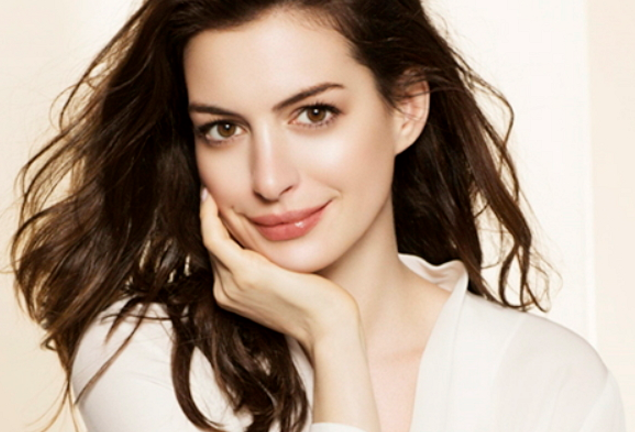

In [ ]:
images

In [ ]:
main(config)

Step [10/1000], Content Loss: 5.1523, Style Loss: 24392.0508
Step [20/1000], Content Loss: 12.9244, Style Loss: 22111.5215
Step [30/1000], Content Loss: 20.2551, Style Loss: 19644.8828
Step [40/1000], Content Loss: 26.9258, Style Loss: 17231.8125
Step [50/1000], Content Loss: 33.0471, Style Loss: 14974.6572
Step [60/1000], Content Loss: 38.6391, Style Loss: 12898.6279
Step [70/1000], Content Loss: 43.7968, Style Loss: 11010.1025
Step [80/1000], Content Loss: 48.5351, Style Loss: 9326.2959
Step [90/1000], Content Loss: 52.8504, Style Loss: 7859.0312
Step [100/1000], Content Loss: 56.7810, Style Loss: 6611.2759
Step [110/1000], Content Loss: 60.3147, Style Loss: 5571.1211
Step [120/1000], Content Loss: 63.4603, Style Loss: 4715.1704
Step [130/1000], Content Loss: 66.1968, Style Loss: 4016.3513
Step [140/1000], Content Loss: 68.5713, Style Loss: 3445.1260
Step [150/1000], Content Loss: 70.6213, Style Loss: 2977.6531
Step [160/1000], Content Loss: 72.3766, Style Loss: 2593.7466
Step [170/1